In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

In [6]:
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]], shape=(569, 30)),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [10]:
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class ANN(nn.Module):
    def __init__(self, input_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.sigmoid(self.fc5(x))
        return x

In [12]:
input_size = X_train.shape[1]
model = ANN(input_size)

In [13]:
criterion = nn.BCELoss()  # Binary Cross-Entropy for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


C:\Users\vrutt\AppData\Roaming\Python\Python313\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
import matplotlib.pyplot as plt


num_epochs = 100  
best_loss = np.inf
early_stop_count = 0
patience = 10 
train_losses = []
val_losses = []

In [15]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  
    
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            y_pred = model(X_val)
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)  
    
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Val Loss: {val_loss:.4f}")

   
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_ann_model.pth")  # Save best model
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/100 - Loss: 0.6638 - Val Loss: 0.6084
Epoch 2/100 - Loss: 0.4770 - Val Loss: 0.2273
Epoch 3/100 - Loss: 0.1634 - Val Loss: 0.0864
Epoch 4/100 - Loss: 0.0857 - Val Loss: 0.0974
Epoch 5/100 - Loss: 0.0806 - Val Loss: 0.0848
Epoch 6/100 - Loss: 0.0667 - Val Loss: 0.0793
Epoch 7/100 - Loss: 0.0602 - Val Loss: 0.0768
Epoch 8/100 - Loss: 0.0870 - Val Loss: 0.0625
Epoch 9/100 - Loss: 0.0521 - Val Loss: 0.0592
Epoch 10/100 - Loss: 0.0568 - Val Loss: 0.0926
Epoch 11/100 - Loss: 0.0371 - Val Loss: 0.0695
Epoch 12/100 - Loss: 0.0572 - Val Loss: 0.0648
Epoch 13/100 - Loss: 0.0600 - Val Loss: 0.0612
Epoch 14/100 - Loss: 0.0571 - Val Loss: 0.0622
Epoch 15/100 - Loss: 0.0423 - Val Loss: 0.0640
Epoch 16/100 - Loss: 0.0361 - Val Loss: 0.0637
Epoch 17/100 - Loss: 0.0494 - Val Loss: 0.0610
Epoch 18/100 - Loss: 0.0413 - Val Loss: 0.0588
Epoch 19/100 - Loss: 0.0385 - Val Loss: 0.0573
Epoch 20/100 - Loss: 0.0420 - Val Loss: 0.0578
Epoch 21/100 - Loss: 0.0406 - Val Loss: 0.0602
Epoch 22/100 - Loss: 0

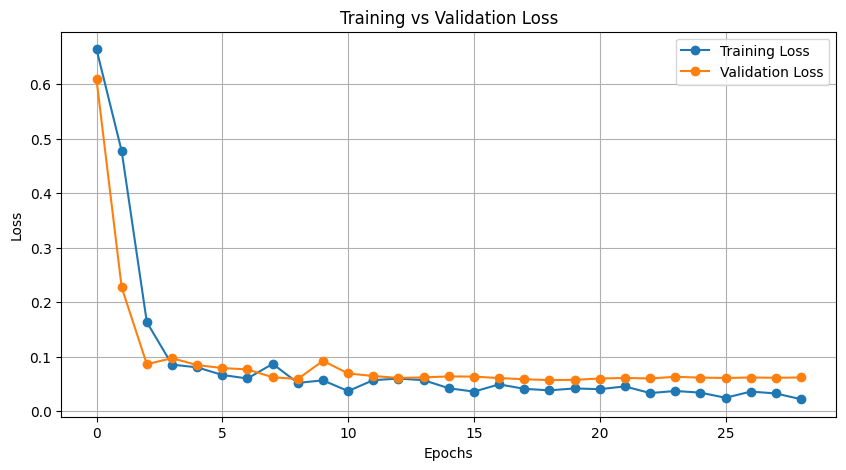

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss", marker='o')
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.load_state_dict(torch.load("best_ann_model.pth"))


model.eval()
correct, total = 0, 0

with torch.no_grad():
    for X_val, y_val in test_loader:
        y_pred = model(X_val)
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_val).sum().item()
        total += y_val.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9912


In [18]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = (predictions > 0.5).float()


print("First 5 Predictions:", predictions[:5].flatten().tolist())


First 5 Predictions: [1.0, 0.0, 0.0, 1.0, 1.0]


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

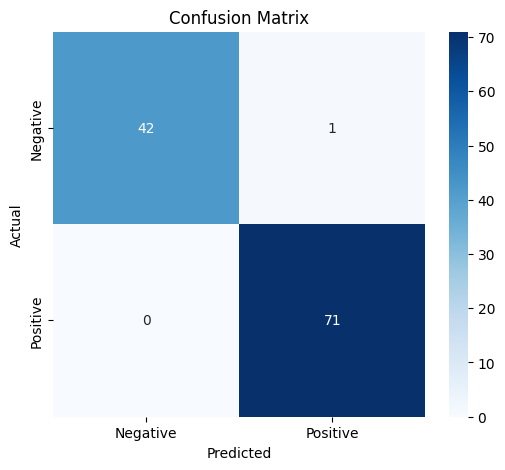

In [20]:
model.eval()
y_pred = model(X_test_tensor).detach().numpy()
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       1.00      0.98      0.99        43
    Positive       0.99      1.00      0.99        71

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

